In [12]:
import numpy as np
from numba import cuda
from timeit import default_timer as timer
%matplotlib inline
import matplotlib.pyplot as plt


In [13]:
# Use a for loop

def add1(a, b):
    # assert(a.shape == b.shape)
    c = np.zeros(a.shape[0])
    for i in range(a.shape[0]):
        c[i] = a[i] + b[i]
    return c

In [14]:
# Make use of Numpy

def add2(a, b):
    # assert(a.shape == b.shape)
    c = a + b
    return c

In [15]:
# Use CUDA

@cuda.jit
def add3(a, b, c, n):
    ix = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if ix < n:
        c[ix] = a[ix] + b[ix]

In [16]:
x = 10**np.arange(2, 8)
t = np.zeros((5, x.size))

for i, n in enumerate(x):
    a = np.ones(n)
    b = np.ones(n)

    start1 = timer()
    c1 = add1(a, b)
    t[0, i] = timer() - start1

    start2 = timer()
    c2 = add2(a, b)
    t[1, i] = timer() - start2


    blockdim = (256)
    griddim = (n // blockdim + 1)
    start3 = timer()
    d_a = cuda.to_device(a)
    d_b = cuda.to_device(b)
    c3 = np.zeros(n)
    d_c = cuda.to_device(c3)

    t[2, i] = timer() - start3 
    add3[griddim, blockdim](d_a, d_b, d_c, n)

    t[3, i] = timer() - start3 - t[2, i]
    d_c.to_host()
    t[4, i] = timer() - start3 - t[2, i] - t[3, i]

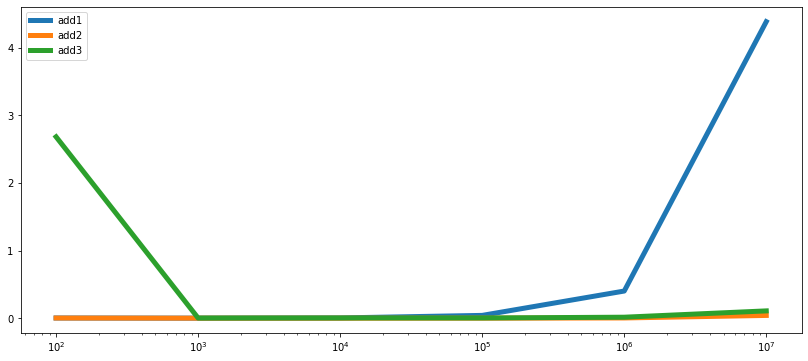

In [17]:
add1_t = t[0]
add2_t = t[1]
add3_t = t[2] + t[3] + t[4]

fig, axs = plt.subplots(1, figsize=(14,6))
axs.plot(x, add1_t, label="add1", linewidth=5.0)
axs.plot(x, add2_t, label="add2", linewidth=5.0)
axs.plot(x, add3_t, label="add3", linewidth=5.0)
axs.set_xscale("log")
axs.legend()

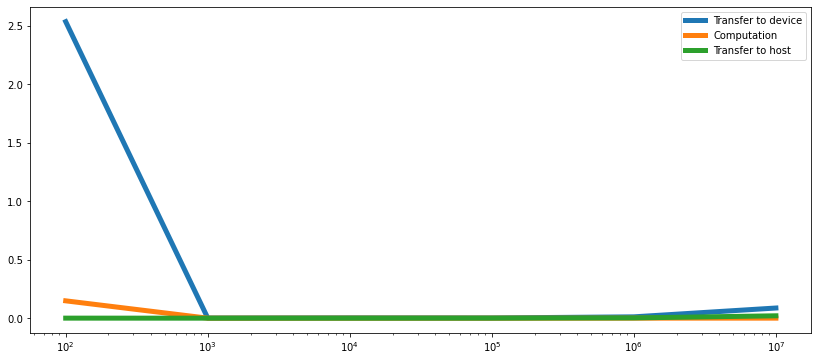

In [18]:
fig, axs = plt.subplots(1, figsize=(14,6))
axs.plot(x, t[2], label="Transfer to device", linewidth=5.0)
axs.plot(x, t[3], label="Computation", linewidth=5.0)
axs.plot(x, t[4], label="Transfer to host", linewidth=5.0)
axs.set_xscale("log")
axs.legend()